# PAN and catchement boundaries analysis

In [212]:
import geopandas as gpd
import pandas as pd
import os
## find the directory of the python (assures compatibility)
python_directory = os.path.abspath("")
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
import math

## Data preparation

Load the maps and PANs

In [213]:
## load the PANs
PANs = pd.read_csv(rf"{python_directory}/data/Yr7_admissions.csv")

## load the maps
schools = gpd.read_file(rf"{python_directory}/data/brighton_sec_schools.geojson")
lsoa = gpd.read_file(rf"{python_directory}/data/BrightonLSOA_Clean.geojson")
students = gpd.read_file(rf"{python_directory}/data/BrightonLSOA_Clean.geojson")
catchment = gpd.read_file(rf"{python_directory}/data/catchment_02.geojson")

## transform lsoa and students dataframes to EPSG:27700 (For the UK)
lsoa.to_crs(epsg="27700", inplace=True)
students.to_crs(epsg="27700", inplace=True)
catchment.to_crs(epsg="27700", inplace=True)

## Print the current CRS
print(f"CRS | schools = {schools.crs}, LSOA = {lsoa.crs}, students LSOA = {students.crs}")


CRS | schools = EPSG:27700, LSOA = EPSG:27700, students LSOA = EPSG:27700


Add columns required for analysis phase

In [214]:
def reset_output_parameters():
    ## Column to assign the total number of students in each school point
    schools["students_total"] = [0 for index in schools.index]
    ## Column to assign the assigned school to each LSOA (to generate the catchement areas)
    students["school"] = ["" for index in lsoa.index]
    students["5_est"] = [math.floor(n * 0.19288) for n in students["5_9_total"]]

reset_output_parameters()
print("Output paramters created in all DataFrames")

Output paramters created in all DataFrames


Plot the maps for visualisation purposes

c:\ProgramData\anaconda3\envs\ABM\lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


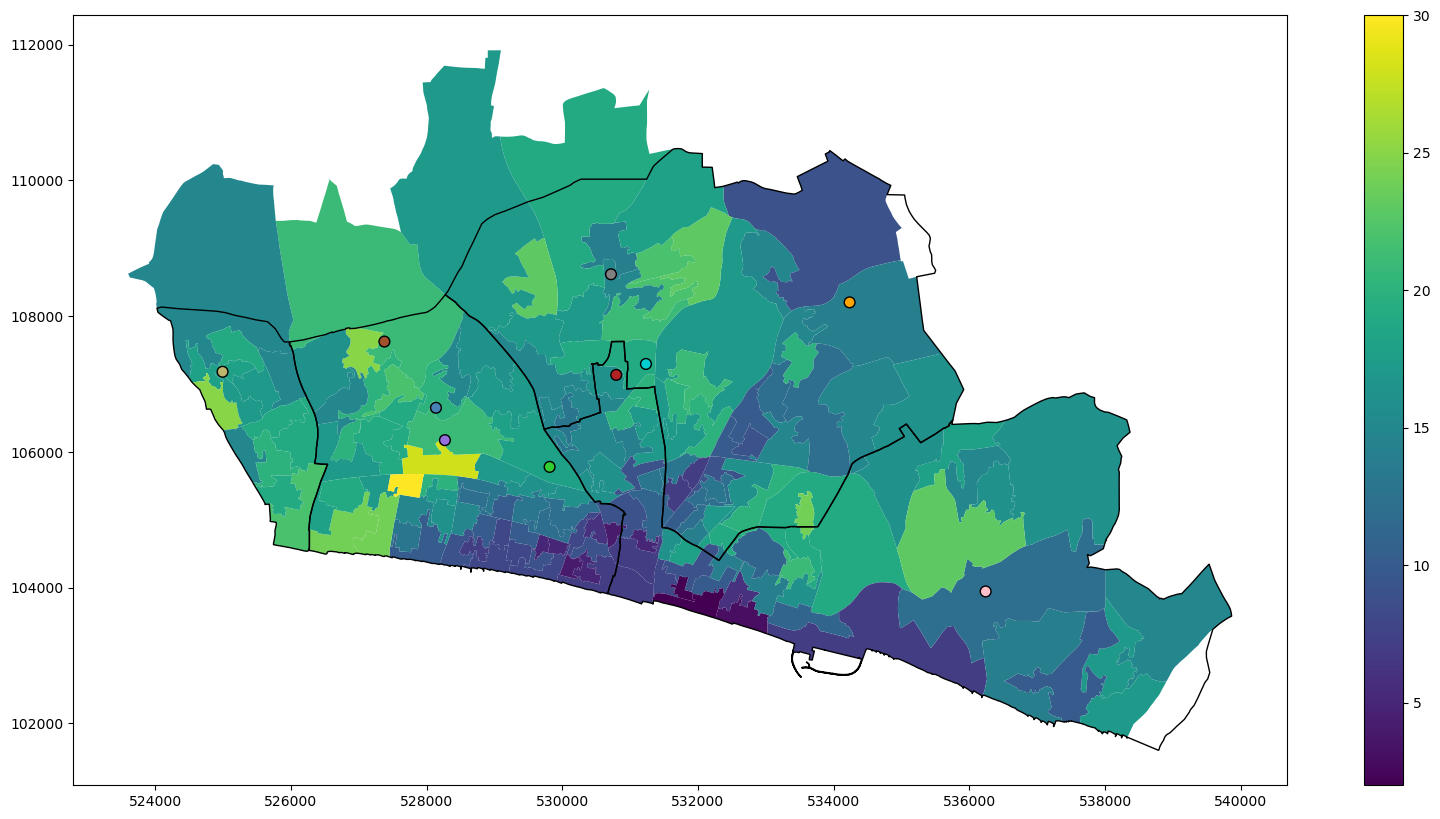

Total students (5 years) = 2433 student


In [223]:
## define colours
colours = {
    "Blatchington Mill School": "steelblue",
    "Brighton Aldridge Community Academy": "orange",
    "Cardinal Newman Catholic School": "limegreen",
    "Dorothy Stringer School": "firebrick",
    "Hove Park School and Sixth Form Centre": "mediumpurple",
    "King's School": "sienna",
    "Longhill High School": "pink",
    "Patcham High School": "gray",
    "Portslade Aldridge Community Academy": "darkkhaki",
    "Varndean School": "darkturquoise",
}

## plot the lsoa with the number of students
fig = students.plot(column="5_est", label="5 to 15 year olds", legend=True, figsize=(20,10))
schools["colour"] = [colours[schools.at[i, "establishment_name"]] for i in schools.index]
schools.plot(ax=fig, column="establishment_name", color=schools["colour"], label="Schools", edgecolor='black', markersize=60, legend=True)
catchment.plot(ax=fig, facecolor="none", edgecolor="black", label="Catchment")
plt.show()
plt.close()

print(f"Total students (5 years) = {sum(students['5_est'])} student")

Find the closes school to each school point

Varndean School
Patcham High School
Cardinal Newman Catholic School
Hove Park School and Sixth Form Centre
Blatchington Mill School
King's School
Portslade Aldridge Community Academy
Brighton Aldridge Community Academy
Longhill High School


c:\ProgramData\anaconda3\envs\ABM\lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


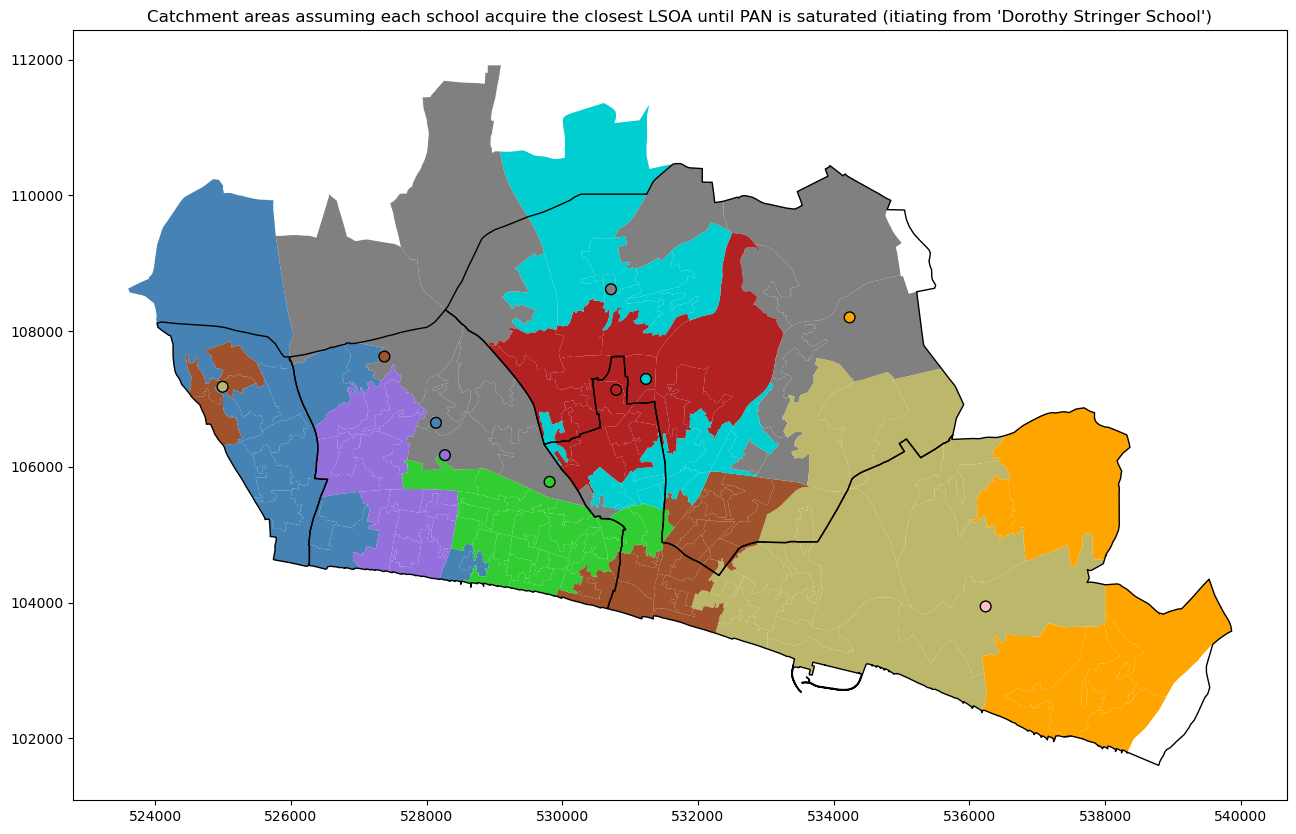

In [227]:
## PAN catchement analysis function version 1
def PAN_Catchment_Schools(
        initial_school="Dorothy Stringer School",
        PAN_year=2024,
        schools=schools,
        students_lsoa=students,
        PANs=PANs,
        ):
    """
    A function that identifyies the catchement areas based on the proposed PANs.

    Parameters
    ----------
    `initial_school`
    `PAN_year`
    `schools`
    `students_losa`
    `PANs`
    """
    ## closest school variables
    schools_temp = copy.deepcopy(schools)
    lsoa_temp = copy.deepcopy(students_lsoa)
    previous_str = None
    ## function inputs
    current_str = initial_school
    ## Extract the PANs for the input year
    target_PAN = {}
    for school_str in PANs["school"]:
        target_PAN[school_str] = int(PANs[PANs["school"] == school_str][f"pan{PAN_year}"])
    # Loop through the schools
    remaining_schools = len(schools_temp.index)
    while remaining_schools > 1:
        ## initial school
        current_school = schools[schools["establishment_name"] == current_str]
        i_cSchool = current_school.index[0]
        ## Accumilate students from the closest LSOAs
        # loop if the PAN is not saturated AND
        # there is still some LSOAs not assigned to a school
        saturated_PAN = False
        while saturated_PAN == False and len(students[students["school"] == ""].index) > 0:
            # find LSOA without an assigned establishment_name
            lsoa_temp = students[students["school"] == ""]
            dists_school_LSOAs = current_school.at[i_cSchool, "geometry"].distance(lsoa_temp["geometry"])
            i_lsoa = dists_school_LSOAs[dists_school_LSOAs == min(dists_school_LSOAs)].index[0]
            ## if adding the number of students in the LSOA will not lead to exceeding the PAN
            if current_school.at[i_cSchool, "students_total"] + students.at[i_lsoa, "5_est"] < target_PAN[school_str]:
                current_school.at[i_cSchool, "students_total"] += students.at[i_lsoa, "5_est"]
                students.at[i_lsoa, "school"] = current_str
            else:
                saturated_PAN = True
        ## Identify next school to analyse
        # drop current school from df
        schools_temp = schools_temp.drop(i_cSchool)
        # find distances
        dists = current_school.at[current_school.index[0],"geometry"].distance(schools_temp["geometry"])
        # find the next closest df (school)
        i_nSchool = dists[dists == min(dists)].index[0]
        next_school = schools.loc[[i_nSchool]]
        print(next_school.at[i_nSchool, "establishment_name"])
        # update current str 
        current_str = next_school.at[i_nSchool, "establishment_name"]
        # update counter
        remaining_schools = len(schools_temp.index)
    
    return {
        "schools": schools,
        "students": students,
    }

reset_output_parameters()
PAN_Catchment_Schools()
students["colour"] = [colours[students.at[i, "school"]] for i in students.index]
fig = students.plot(column="school", color=students["colour"], label="5 to 15 year olds", legend=True, figsize=(20,10))
schools.plot(ax=fig, color=schools["colour"], label="Schools", edgecolor='black', markersize=60, legend=True)
catchment.plot(ax=fig, facecolor="none", edgecolor="black", label="Catchment")
plt.title("Catchment areas assuming each school acquire the closest LSOA until PAN is saturated (itiating from 'Dorothy Stringer School')")
plt.show()
plt.close()
